## COGS 18 Project: Developing a SIR Model

This project utilizes public health data (for COVID-19) in order to create SIR models for predicting infectious disease rates over time. 

This data visualization takes a CSV file from the CDC containing COVID-19 data from 2021-2022 and an XLSX file from the US Census containing updated state populations (for 2021). Firstly, data will be cleaned, organized, and joined to create a compact table with data necessary for epidemiological calculations. Then two functions are established to perform these calculations. 
- The first calculates the infected proportion of the population (i) and append it with susceptible population (s) and recovered proportion of the population (r).
- The second function utilizes infection rate (e) and recovery rate (b) to calculate derivatives of s, i, and r by a function of time.

Together the outputs of these functions are utilized for integrating the dataframe data into something that can be plotted for visualization.

In order to visualize the data, the program takes user input for a state (with a state abbreviation) and a date (as long as it's included in the original CDC dataset) and creates a SIR model utilizing the complimentary data to their input.

**It's important to note that data available is limited and SIR models do not fully factor in outside variables (only strictly uses disease transmission data) so recovery rates will artificially level out sooner than observed patterns, so this is more of a basis for more complex programming**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import pytest
from IPython import display

Dataset acquired from CDC at https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36/data

Contains data for COVID-19 in the United States

Dataset acquired from US Census at https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html#par_textimage_1574439295

Contains population data for the United States

Resource for SIR model https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model

In [2]:
covid_df = pd.read_csv('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time_-_ARCHIVED.csv')

In [3]:
covid_df.head() # checking dataset

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,03/11/2021,KS,297229,241035.0,56194.0,0,0.0,4851,NaN,NaN,0,0.0,03/12/2021 03:20:13 PM,Agree,NaN
1,12/01/2021,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree
2,01/02/2022,AS,11,NaN,NaN,0,0.0,0,NaN,NaN,0,0.0,01/03/2022 03:18:16 PM,NaN,NaN
3,11/22/2021,AL,841461,620483.0,220978.0,703,357.0,16377,12727.0,3650.0,7,3.0,11/22/2021 12:00:00 AM,Agree,Agree
4,05/30/2022,AK,251425,NaN,NaN,0,0.0,1252,NaN,NaN,0,0.0,05/31/2022 01:20:20 PM,NaN,NaN


#### Data Cleaning:

For the purpose of this project, only the follow columns are needed:
- submission_date
- state
- tot_cases (total cases)
- new_case (new cases)
- tot_death (total deaths)
- new_death (new deaths)

Submission date (submission_date) and State (state) will be utilized to index the rest of the variables for calculations. Total cases (tot_cases) will be used to calculate i (proportion of infected individuals), and the remaining variables will be left to compare values to the model.

In [4]:
# Declaring columns
covid_df.columns = ['submission_date','state','tot_cases','conf_cases','prob_cases','new_case','pnew_case','tot_death',
                    'conf_death','prob_death','new_death','pnew_death','created_at','consent_cases','consent_deaths']

In [5]:
# Dropping columns for data that will not be used
covid_df = covid_df.drop(columns=['conf_cases','prob_cases','pnew_case','conf_death','prob_death','pnew_death','created_at',
                         'consent_cases','consent_deaths'])

In [6]:
covid_df['submission_date'].dtypes # Checking datatype

dtype('O')

In [7]:
covid_df['submission_date'].astype(str) # Changing submission date datatype to string

0        03/11/2021
1        12/01/2021
2        01/02/2022
3        11/22/2021
4        05/30/2022
            ...    
60055    02/09/2021
60056    11/20/2020
60057    08/17/2020
60058    06/17/2020
60059    05/07/2022
Name: submission_date, Length: 60060, dtype: object

This dataset will be narrowed down to submissions on 10/18/2021 and 10/18/2022 for this project to simplify options. (As well as opening an opportunity to possibly perform more advanced ML-based programming to create more accurate predictive models in the future.)

In [8]:
# Narrowing down dataframe to 10/18 for 2021 and 2022
covid_df = covid_df[(covid_df['submission_date']=='10/18/2021') | (covid_df['submission_date']=='10/18/2022')]

In [9]:
covid_df.head() # checking if only wanted columns are left

,submission_date,state,tot_cases,new_case,tot_death,new_death
212,10/18/2021,ND,142407,923,1690,10
295,10/18/2022,IA,861010,844,10152,27
366,10/18/2022,NY,3275131,1660,29356,32
390,10/18/2022,NM,623179,266,8601,0
413,10/18/2021,GU,17154,163,226,3


In [10]:
# Organizing dataframe by date from oldest to newest
covid_df = covid_df.sort_values(by='submission_date')

In [11]:
covid_df.head()

,submission_date,state,tot_cases,new_case,tot_death,new_death
212,10/18/2021,ND,142407,923,1690,10
38226,10/18/2021,NJ,1182051,767,27737,12
36575,10/18/2021,WY,98165,344,1080,0
36275,10/18/2021,MD,551264,714,10749,12
33301,10/18/2021,NE,276814,155,2920,8


Before creating a prediction model, a SIR model will be established to visualize changes over time across states.

A SIR model is a statistical model in epidemiology that depicts individuals in a population who are:
- Susceptible (S)
- Infected (I)
- Recovered (R)

Variables for this model will be indicated by:
- S = total susceptible population (population - tot_cases)
- I = total infections (tot_cases)
- R = 0 for initial population (or if/when comparing submission_dates when tot_cases (of an earlier date) - tot_cases (of a later date) > 0, then R = this value)

Lower case letters (s,i,r) will be utilized once scaled:
- s = S/S (proportion of susceptible population)
- i = I/S (proportion of infected population)
- r = R/S (proportion of recovered population)

The visualizations will utilize the scaled variables.

In [12]:
state_populations = pd.read_excel('NST-EST2021-POP.xlsx')

In [13]:
state_populations = state_populations.rename(columns={"""table with row headers in column A and column headers in rows 3 through 
                                                      4. (leading dots indicate sub-parts)""":'state','Unnamed: 3':'2021 population'})
state_populations = state_populations.drop(columns=['Unnamed: 1','Unnamed: 2'])
state_populations = state_populations.drop([0,1,2,3,4,5,6,7,59,60,61,62,63,64,65])

In [14]:
state_populations.columns = ['state','2021 population']

In [15]:
# Checking datatypes
state_populations['2021 population'].dtypes # Want it to be a float/int

dtype('float64')

In [16]:
state_populations['state'].dtypes # Want it to be a string

dtype('O')

In [17]:
# Converting dtype Object to String
state_populations['state'].astype(str)

8                  .Alabama
9                   .Alaska
10                 .Arizona
11                .Arkansas
12              .California
13                .Colorado
14             .Connecticut
15                .Delaware
16    .District of Columbia
17                 .Florida
18                 .Georgia
19                  .Hawaii
20                   .Idaho
21                .Illinois
22                 .Indiana
23                    .Iowa
24                  .Kansas
25                .Kentucky
26               .Louisiana
27                   .Maine
28                .Maryland
29           .Massachusetts
30                .Michigan
31               .Minnesota
32             .Mississippi
33                .Missouri
34                 .Montana
35                .Nebraska
36                  .Nevada
37           .New Hampshire
38              .New Jersey
39              .New Mexico
40                .New York
41          .North Carolina
42            .North Dakota
43                  

In [18]:
# Removing the '.' so the state column is only the state name
state_populations['state'] = state_populations['state'].str.replace('.','')

C:\Users\chask\AppData\Local\Temp/ipykernel_24952/404658065.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  state_populations['state'] = state_populations['state'].str.replace('.','')


In [19]:
state_populations.head()

,state,2021 population
8,Alabama,5039877.0
9,Alaska,732673.0
10,Arizona,7276316.0
11,Arkansas,3025891.0
12,California,39237836.0


The following dictionary was copied from Roger Allen's github at the following link: https://gist.github.com/rogerallen/1583593

In [20]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"}

In [21]:
# Utilizing the dictionary to change the full state name to the abbreviation to utilize for joining with covid_df
state_populations['state'] = state_populations['state'].map(us_state_to_abbrev)

In [22]:
state_populations.head()

,state,2021 population
8,AL,5039877.0
9,AK,732673.0
10,AZ,7276316.0
11,AR,3025891.0
12,CA,39237836.0


In [23]:
# Combining dataframes using an inner join on state data (will merge state column and add all non-matching columns[population])
total_data = state_populations.merge(covid_df, how = 'inner', on = ['state'])

In [24]:
# Checking if join worked as intended
total_data.head()

,state,2021 population,submission_date,tot_cases,new_case,tot_death,new_death
0,AL,5039877.0,10/18/2021,810974,1041,15948,26
1,AL,5039877.0,10/18/2022,1530803,392,20526,4
2,AK,732673.0,10/18/2021,124751,691,642,16
3,AK,732673.0,10/18/2022,284076,0,1356,0
4,AZ,7276316.0,10/18/2021,1135748,1886,20614,57


In [25]:
# Checking datatypes after merging into new dataframe
total_data['state'].dtypes

dtype('O')

In [26]:
total_data['2021 population'].dtypes

dtype('float64')

In [27]:
total_data['submission_date'].dtypes

dtype('O')

In [28]:
# Want state and submission_date as strings
total_data['state'].astype(str)
total_data['submission_date'].astype(str)

0     10/18/2021
1     10/18/2022
2     10/18/2021
3     10/18/2022
4     10/18/2021
         ...    
95    10/18/2022
96    10/18/2021
97    10/18/2022
98    10/18/2021
99    10/18/2022
Name: submission_date, Length: 100, dtype: object

In [29]:
# This function creates a list containing scaled variables [s,i,r] for population proportions

def SIR(state, date):
    
    """
    This function is automatically run when accessing data visualization. It takes the user input for state and date, and
    accesses the appropriate values from the total_data dataframe to calculate proportion of infected individuals (i) and
    appends all of this data in a list for further calculation.
    """
    
    sir = []
    s = 1
    r = 0
    i = np.where((total_data['state'] == state) &
                (total_data['submission_date'] == date),
                (total_data['tot_cases']/total_data['2021 population']), None)
    
    for val in i:
        if val != None:
            i = val
    
    sir.append(s)
    sir.append(i)
    sir.append(r)
    
    return sir

To graph a SIR model, derivatives of S,I,R must be presented.

Placeholder values (unless data is found):
- Infection rate (e) = 1
- Recovery rate (b) = 0.5

In [30]:
e = 1 # infection rate
b = 0.5 # recovery rate

# Calculates derivatives of S, I, and R as functions of time 
def deriv(y,t):
    
    """
    This function is automatically run when accessing data visualization. It sets up a list y using the S, I, and R data
    established. e indicates the infection rate and b indicates the recovery rate [These values need to be established prior
    to running the function.]. It returns the derivatives of s, i, and r as functions of time in a list for further 
    visualization calculation.
    """
    
    S, I, R = y 
    ds = -e*S*I # derivative of S(t)
    di = e*S*I - b*I # derivative of I(t)
    dr = b*I # derivative of R(t)

    return [ds,di,dr]

The code below indicates where a user can enter a state/date to produce a SIR model using given data of that state as of the given date.

In [31]:
def sir_model():
    
    """
    This function visualizes the SIR model using calculated values from the SIR and deriv functions. It takes a user input
    for state and date to perform these calculations and create a plot for the SIR model.
    """
    
    sir = SIR(input('Enter a state abbreviation: '), input('Enter a date: '))

    t = np.linspace(start=1,stop=50,num=1000)
    y = odeint(deriv,sir,t) 

    S = y[:,0]
    I = y[:,1]
    R = y[:,2]

    plt.figure()
    plt.plot(t,S,"r",label="S(t)")
    plt.plot(t,I,'b',label="I(t)")
    plt.plot(t,R,'g',label="R(t)")
    plt.legend()
    plt.show()

To create new SIR models, run the function sir_model() then provide appropriate input.

Example:

- sir_model()
- 'Enter a state abbreviation:' *Enter one of the 50 state's abbreviations*
- 'Enter a date:' *10/18/2021* or *10/18/2022* in this exact format

Function tests:

In [32]:
# Testing the SIR() function
assert SIR('AZ','10/18/2021') == [1, 0.15608832821444257, 0]
assert SIR('IL', '10/18/2021') == [1, 0.13189275844813259, 0]
assert SIR('NY', '10/18/2022') == [1, 0.16511117990888546, 0]
assert SIR('FL','10/18/2022') == [1, 0.32807451478178723, 0]

# Testing the deriv() function
assert deriv([(732673 - 284076),284076,0],10) == [-127435641372, 127435499334.0, 142038.0] # For AK, 10/18/2022
assert deriv([(5039877 - 810974),810974,0],10) == [-3429530381522, 3429529976035.0, 405487.0] # For AL 10/18/2021

Example Outputs:

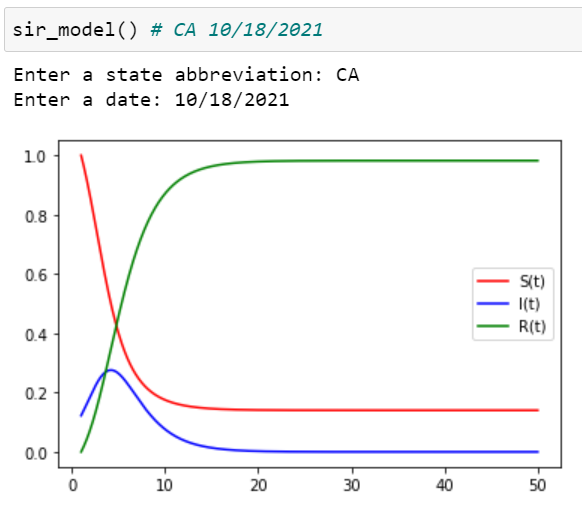

In [35]:
display.Image('sir_model_tests/sir_model_CA21.png')

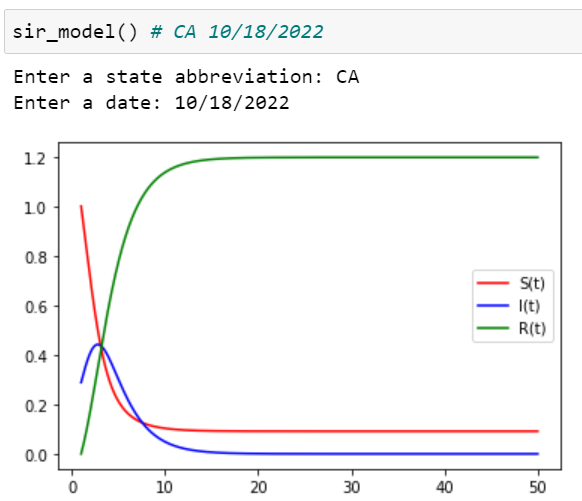

In [36]:
display.Image('sir_model_tests/sir_model_CA22.png')